This notebook aims at generating a LSTM-type model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

2025-11-03 11:46:54.353747: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_path = './data/export_infoclimat_filtered.csv'

df = pd.read_csv(file_path)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1044 non-null   object 
 1   temperature  1044 non-null   float64
 2   humidite     1044 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.6+ KB
None
                  date  temperature  humidite
0  2025-10-04 03:00:00         14.7        96
1  2025-10-04 03:10:00         14.4        97
2  2025-10-04 03:20:00         14.3        97
3  2025-10-04 03:30:00         14.1        97
4  2025-10-04 03:40:00         14.0        97


Filter the data set

In [3]:
numeric_cols = ['temperature']
data_selected = df[numeric_cols]
data_selected.shape

(1044, 1)

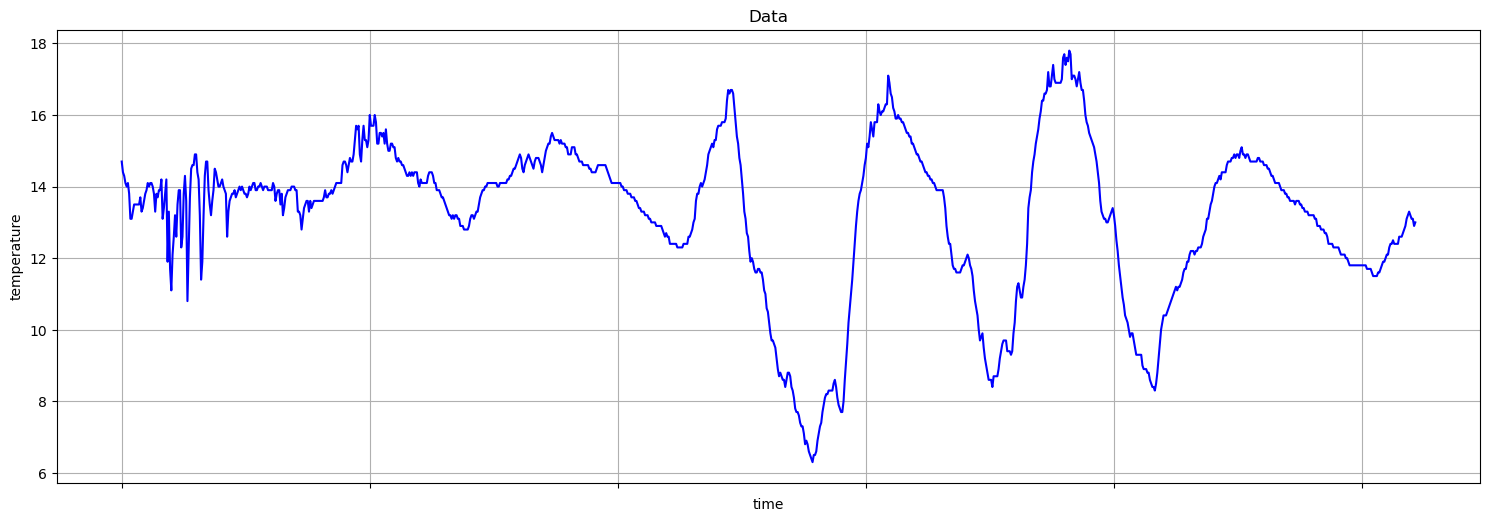

In [4]:
colors = ['blue', 'green']
n_features = len(colors)
plt.figure(figsize=(15, 10))

for i, (feature, color) in enumerate(zip(data_selected.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)
    data_selected[feature].plot(ax=ax, color=color)
    ax.set_title("Data")
    ax.set_xlabel('time')
    ax.set_ylabel(feature)
    ax.grid(True)

    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Make the data smooth

In [5]:
data_selected = data_selected.groupby(data_selected.index // 3).mean()[150:] # basically sampling every 3*10min = 30min (skip the first 150)
data_selected.shape

(198, 1)

Display smoothed data

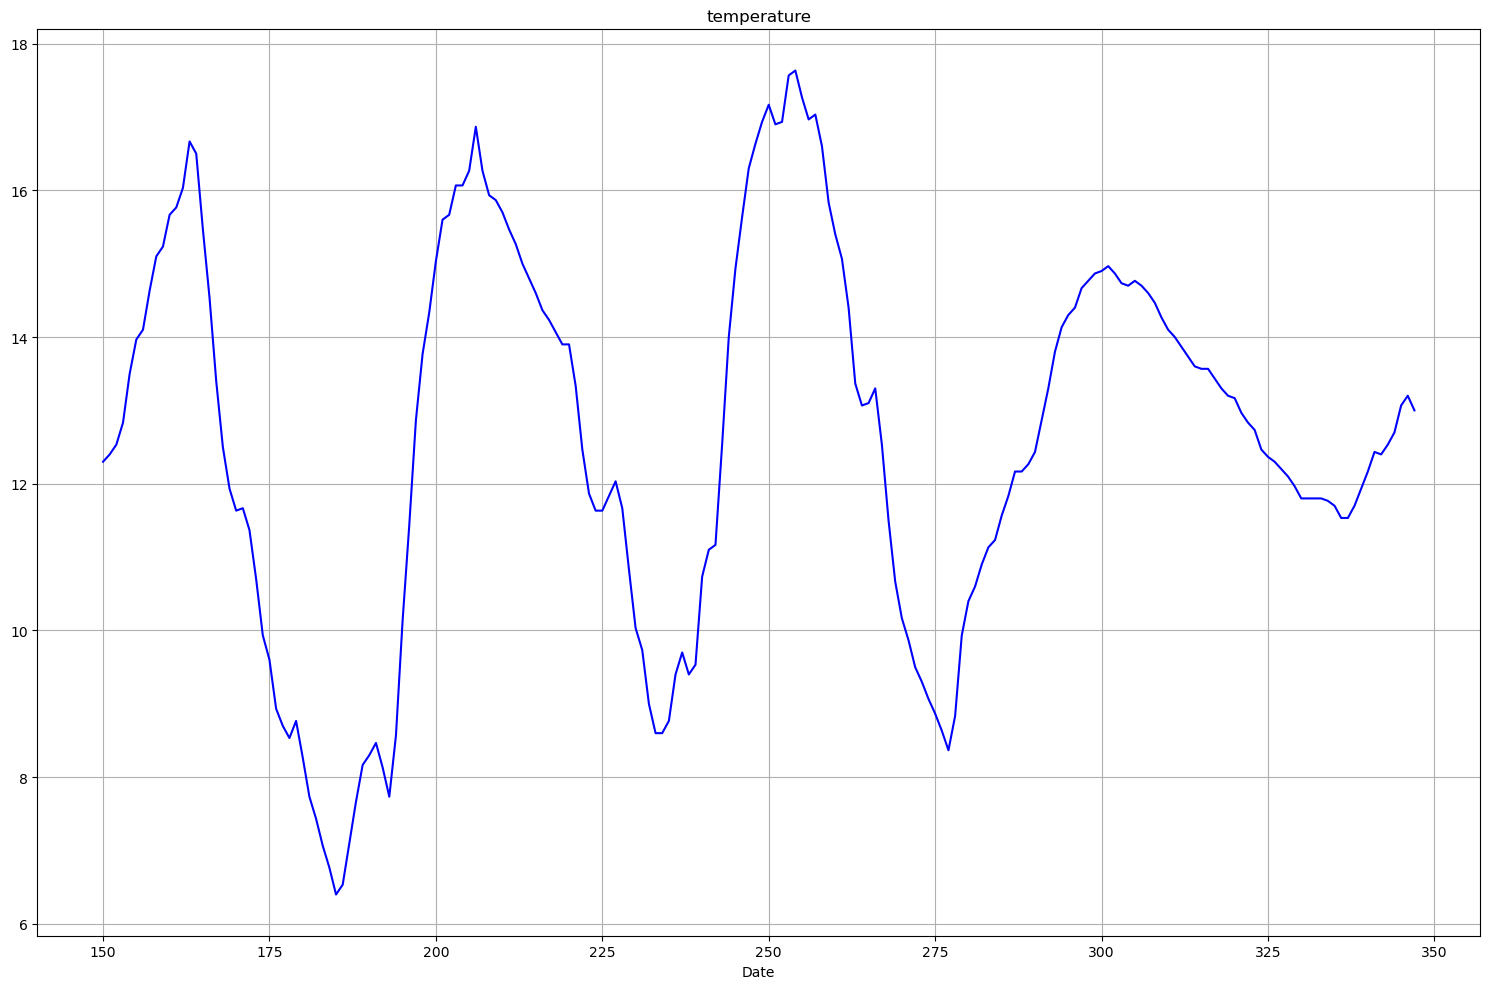

In [6]:
colors = ['blue']
n_features = len(colors)
plt.figure(figsize=(15, 10))

for i, (feature, color) in enumerate(zip(data_selected.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)
    data_selected[feature].plot(ax=ax, color=color)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.grid(True)

    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Split data into train test sets with a ratio of 85%

In [7]:
train_size = int(len(data_selected) * .85)
train_data = data_selected[:train_size]
test_data = data_selected[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (168, 1)
Test data shape: (30, 1)


`create_sequences` is a function design to feed the model with data of `seq_lenth` size. We usually set the sequence to 48 

In [8]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # <- small sequence < 24h makes the model perform very bad
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (158, 10, 1)
y_train shape: (158, 1)
X_test shape: (20, 10, 1)
y_test shape: (20, 1)


In [9]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
%%capture

model = Sequential([
    LSTM(16,
         return_sequences=False,
         dropout=0.2,  # dropout is used to reduce overfitting
         recurrent_dropout=0.2, 
         input_shape=(seq_length, 1)),
    Dense(8, activation='relu'),
    Dense(1)])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    loss='mse',
    metrics=['mae']
)
model.summary()

2025-11-03 11:46:56.015153: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
# Callbacks : stop the training with the model isn't learning anymore
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.005,
    verbose=1
)

In [13]:
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_split=0.2,  # 20% used for validation
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    shuffle=True
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.3336 - mae: 0.5080 - val_loss: 0.3806 - val_mae: 0.6122 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2769 - mae: 0.4558 - val_loss: 0.3183 - val_mae: 0.5596 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2221 - mae: 0.3989 - val_loss: 0.2506 - val_mae: 0.4961 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1647 - mae: 0.3374 - val_loss: 0.1813 - val_mae: 0.4215 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1186 - mae: 0.2761 - val_loss: 0.1150 - val_mae: 0.3348 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0846 - mae: 0.2317 - val_loss: 0.0600 - val_mae: 0.2395 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0604 - mae: 0.2027 - val_loss: 0.0250 - val_mae: 0.1504 - learning_rate: 0.0010
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━

Plot the training / testing loss 

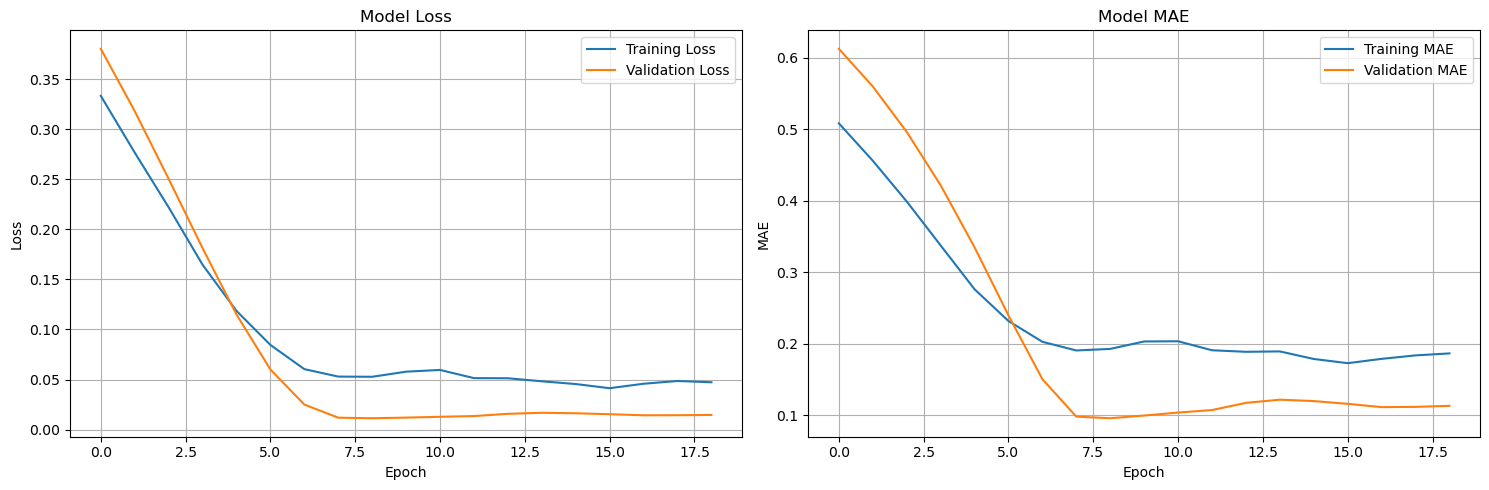

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Predict the next output

In [15]:
pred = model.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Denormalize predictions

In [16]:
tmp = np.zeros((len(pred), 2))
tmp[:, 0] = pred
pred_denorm = scaler.inverse_transform(tmp)[:, 0]

Denormalize test values

In [17]:
tmp_t = np.zeros((len(y_test), 2))
tmp_t[:, 0] = y_test.flatten()
y_test_denorm = scaler.inverse_transform(tmp_t)[:, 0]

Manage indexes for display

In [18]:
start_idx = train_size + seq_length
pred_indices = np.arange(start_idx, start_idx + len(pred_denorm))

Few metrics

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_denorm, pred_denorm)
mae = mean_absolute_error(y_test_denorm, pred_denorm)
r2 = r2_score(y_test_denorm, pred_denorm)
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

MSE: 0.2432
MAE: 0.4463
R²: 0.0542
RMSE: 0.4932


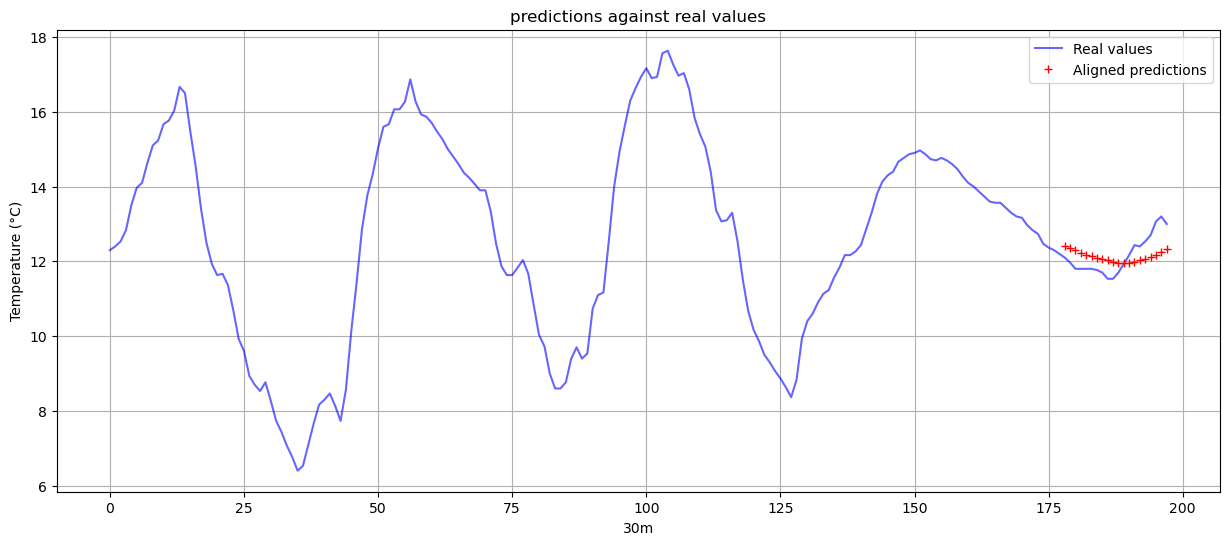

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(data_selected)), data_selected['temperature'].values, label='Real values', color='blue', alpha=0.6)
plt.plot(pred_indices, pred_denorm, label='Aligned predictions', color='red', marker='+', linestyle='None')
plt.title('predictions against real values')
plt.xlabel('30m')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

Recursive predictions function : the model feeds with its own last output to predict the next value

In [21]:
def predict_recursive(model, initial_sequence, n_steps, scaler):
    current_seq = initial_sequence.copy().reshape(-1, 1)  # (seq_length, 1)
    predictions = []
    
    for _ in range(n_steps):
        # Predict the next step
        current_input = current_seq.reshape(1, len(current_seq), 1)  # (1, seq_length, 1)
        next_pred = model.predict(current_input, verbose=0)[0, 0]
        
        # Store predictions
        predictions.append(next_pred)
        
        # Update sequence: delete the first timestep and add the next prediction
        current_seq = np.vstack([current_seq[1:], [[next_pred]]])
    
    predictions = np.array(y_test).reshape(-1, 1)
    predictions_denorm = scaler.inverse_transform(predictions).flatten()
    
    return predictions_denorm

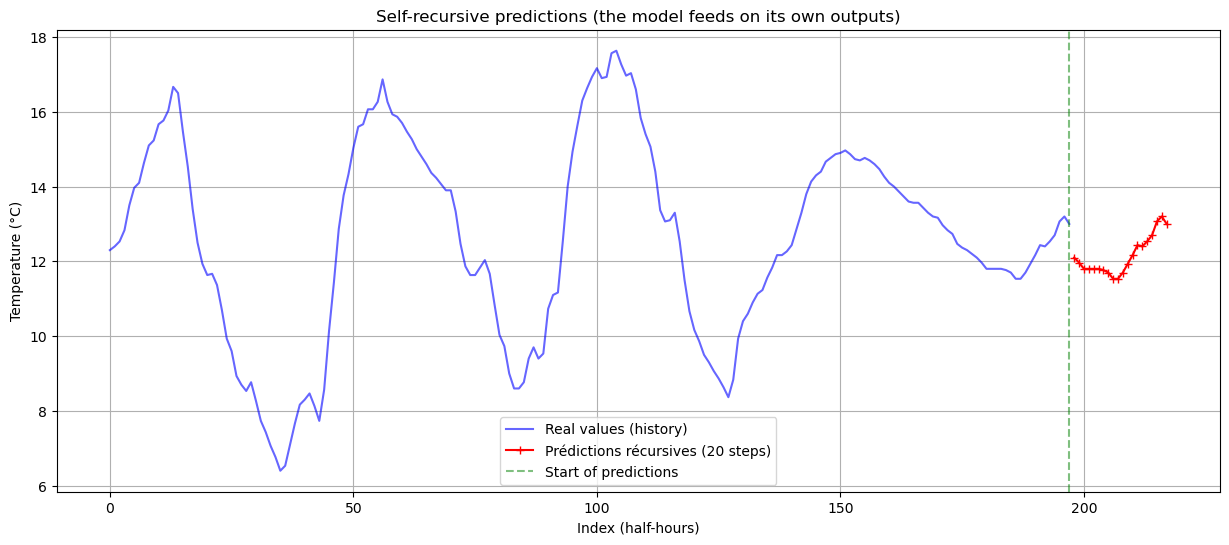

Predicted temperature in 20 half-hours: 13.00°C


In [22]:
# Let's predict the next 100 steps (50 hours) from the last test sequence
initial_seq = test_scaled[-seq_length:]  # last test sequence
n_future_steps = 20 # 20 half-hours

recursive_pred = predict_recursive(model, initial_seq, n_future_steps, scaler)

# Indices for the display (after test data)
start_recursive_idx = len(data_selected)
recursive_indices = np.arange(start_recursive_idx, start_recursive_idx + len(recursive_pred))

# Display
plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(data_selected)), data_selected['temperature'].values, 
         label='Real values (history)', color='blue', alpha=0.6)
plt.plot(recursive_indices, recursive_pred, 
         label=f'Prédictions récursives ({n_future_steps} steps)', 
         color='red', marker='+', linestyle='-')
plt.axvline(x=len(data_selected)-1, color='green', linestyle='--', alpha=0.5, label='Start of predictions')
plt.title('Self-recursive predictions (the model feeds on its own outputs)')
plt.xlabel('Index (half-hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Predicted temperature in {n_future_steps} half-hours: {recursive_pred[-1]:.2f}°C")